<p align="center"><font size="18">Проект для «Викишоп»</font></p>

# Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис.
Пользователи смогут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Наша задача:<br>
Обучить модель классифицировать комментарии на позитивные и негативные, со значением метрики качества F1 не меньше 0.75. В нашем распоряжении набор данных с разметкой о токсичности правок.

В данных: столбец 'text' содержит текст комментария, а 'toxic' — целевой признак.

***

In [6]:
# установка библиотек
!pip install -U imbalanced-learn

In [7]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

from tqdm import notebook

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

***

# Подготовка данных

In [8]:
# монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/My Drive/git_projects/2_classification_comments'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
text_toxic.ipynb  toxic_comments.csv


In [9]:
# загрузка данных
df = pd.read_csv('drive/My Drive/git_projects/2_classification_comments/toxic_comments.csv')

In [10]:
# первые три стороки
df.head(3)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0


In [11]:
# удалим 'Unnamed: 0'
df = df.drop(columns='Unnamed: 0')

In [12]:
# информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [13]:
# дубликаты
df.duplicated().sum()

0

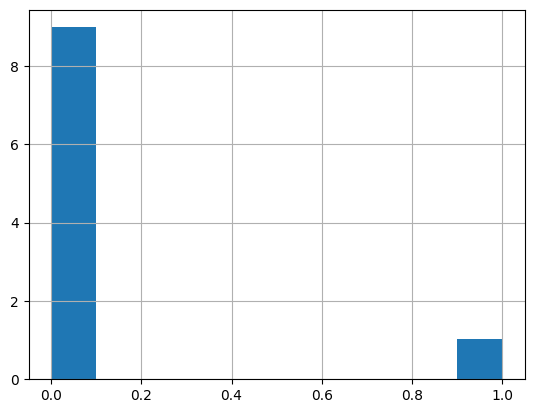

In [14]:
# баланс классов
plt.grid(True)
plt.hist(df.toxic, density=True)
plt.show()

Оставим в тексте только символы латиницы и пробелы, цифры и знаки препинания не несут информацию о "токсичности". Слова приведем в нижний регистр, так одни и те же слова с заглавной и прописной буквы не будут восприниматься как разные.

In [15]:
# оставим в тексте только символы латиницы и пробелы
# слова преведем в нижний регистр
df['text'] = df['text'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z ]', ' ', x.lower()).split()))

In [16]:
# corpus
corpus = df['text'].values

In [17]:
# лемматизация
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
corpus_lemm = []
for text in notebook.tqdm(corpus):
    text_lemm = " ".join([token.lemma_ for token in nlp(text)])
    corpus_lemm.append(text_lemm)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [18]:
# corpus_lemm в массив
corpus_lemm = np.array(corpus_lemm)

In [19]:
# выборки тестовая и обучающая
X_train, X_test, y_train, y_test = train_test_split(
    corpus_lemm, df['toxic'], test_size=.1, random_state=22)

In [20]:
# stopwords
# tf_idf
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(max_df=.7, min_df=.0001, stop_words=list(stopwords))
X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)

X_train.shape, X_test.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


((143362, 12702), (15930, 12702))

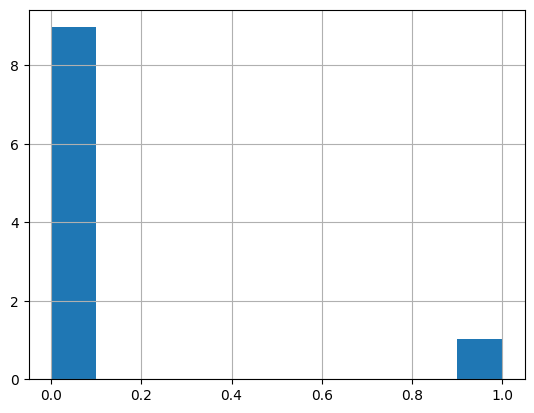

In [21]:
# баланс классов 'y_test'
plt.grid(True)
plt.hist(y_test, density=True)
plt.show()

## Заключение
В наших даных:
- 159_292 текста
- дубликатов не обнаружено
- обнаружен дисбаланс классов в целевом признаке 'toxik', соотношение 9/1, уменьшали дисбаланс с RandomUnderSampler
- провели предобработку текста:
    - оставим в тексте только символы латиницы и пробелы, слова привели в нижний регистр
    - провели лемматизация с помощью библиотеки spacy
    - удалили стоп-слова
    - вычислили tf_idf
    - подготовили выборки для подбора моделей

---

# Модели

## LogisticRegression

In [22]:
# RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=22)

In [23]:
# логистическая регрессия c RandomUnderSampler.
lr = LogisticRegression()

imba_pipeline = make_pipeline(rus, lr)
scores = cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=5)

print(scores)
print(scores.mean())

[0.77171434 0.77536615 0.77896208 0.77580702 0.78201058]
0.7767720358764053


## LGBMClassifier

In [24]:
%%time
# cоздадим, обучим и подберем параметры для LGBMClassifier
lgbc = LGBMClassifier(random_state=22)
imba_pipeline = make_pipeline(rus, lgbc)

parametrs = {
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 7, 9, 11],
    'num_leaves': [30]
    }

params = {'lgbmclassifier__' + key: parametrs[key] for key in parametrs}

grid = GridSearchCV(
    imba_pipeline,
    param_grid=params,
    cv=3,
    scoring='f1',
    n_jobs=-1
    )

grid.fit(X_train, y_train)


print('Лучший результат:')
print('гиперпараметры: ', grid.best_params_)
print('F1: ', grid.best_score_)

Лучший результат:
гиперпараметры:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 11, 'lgbmclassifier__n_estimators': 200, 'lgbmclassifier__num_leaves': 30}
F1:  0.7722397831042516
CPU times: user 45.6 s, sys: 1.44 s, total: 47 s
Wall time: 9min 43s


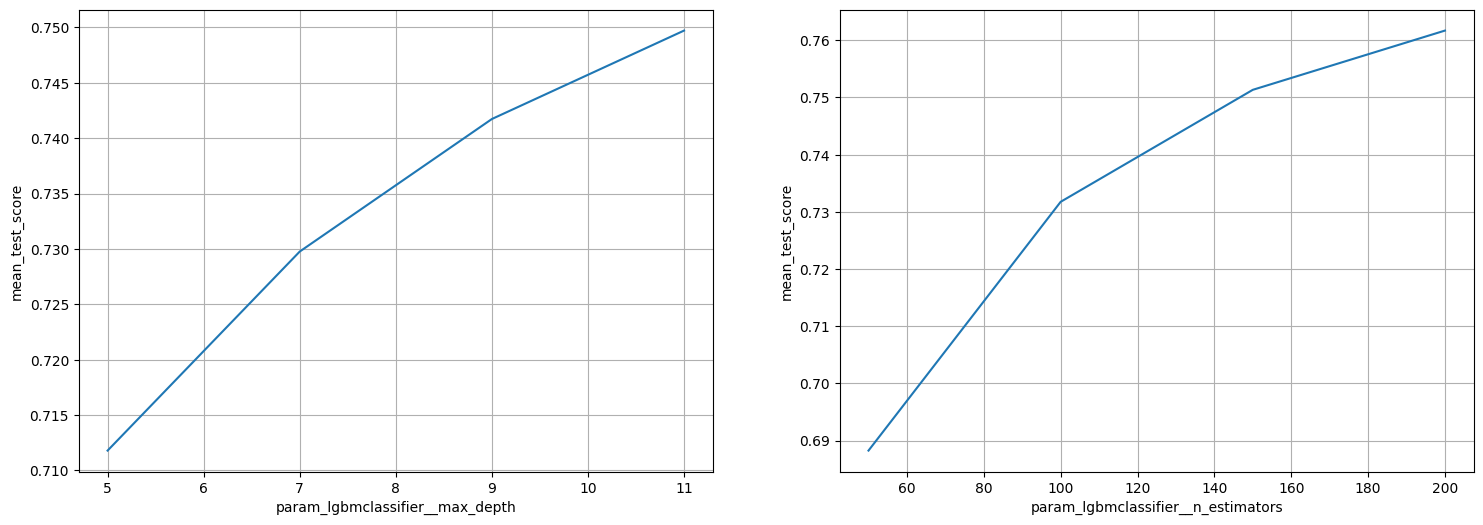

In [25]:
# построим графики
# зависимость 'mean_test_score' от 'param_max_depth'
# зависимость 'mean_test_score' от 'param_n_estimators'

grid_res = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(1,2)
sns.lineplot(data=grid_res.groupby(
    'param_lgbmclassifier__max_depth')['mean_test_score'].mean(), ax=ax[0])

sns.lineplot(data=grid_res.groupby(
    'param_lgbmclassifier__n_estimators')['mean_test_score'].mean(), ax=ax[1])

ax[0].grid()
ax[1].grid()
fig.set_figheight(6)
fig.set_figwidth(18)
fig.show()

## Зключение
Исследовали две модели с разными алгоритмами предсказания LogisticRegression и LGBMClassifier, подбирали гиперпараметры.<br> Результаты на валидации F1:<br> LogisticRegression - 0.819<br> LGBMClassifier - 0.817

Метрики практически одинаковы, но LogisticRegression значительно быстрее работает и менее ресурсозатратна, выведем ее на тест.

---

# Тест

In [26]:
# RandomUnderSampler
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)

In [27]:
# тест LogisticRegression
lr.fit(X_train_down, y_train_down)
pred = lr.predict(X_test)
f1_score(y_test, pred)

0.7751314568512219

In [28]:
# адекватность модели
pred_random = pd.Series(
    np.ones((len(y_test))),
    index=y_test.index)

f1_score(y_test, pred_random)

0.18637217510104173

---

# Итоги
В ходе  нашей работы мы:
1. Провели предобработку:
    - ознакомились с данными
    - обнаружили дисбаланс классов в целевом признаке 'toxik', уменьшали его с RandomUnderSampler
    - обработали тексты, оставили только символы латиницы и пробелы
    - привели в нижний регистр
    - провели лемматизация с помощью библиотеки spacy
    - удалили стоп-слова
    - вычислили tf_idf
    - подготовили выборки для подбора моделей
2. Подобрали модель для предсказания класса, LogisticRegression, метрика F1 на валидации:0.82, вывели ее на тест.
3. Результаты на тесте F1: 0.77, что выполняет условие заказчика.